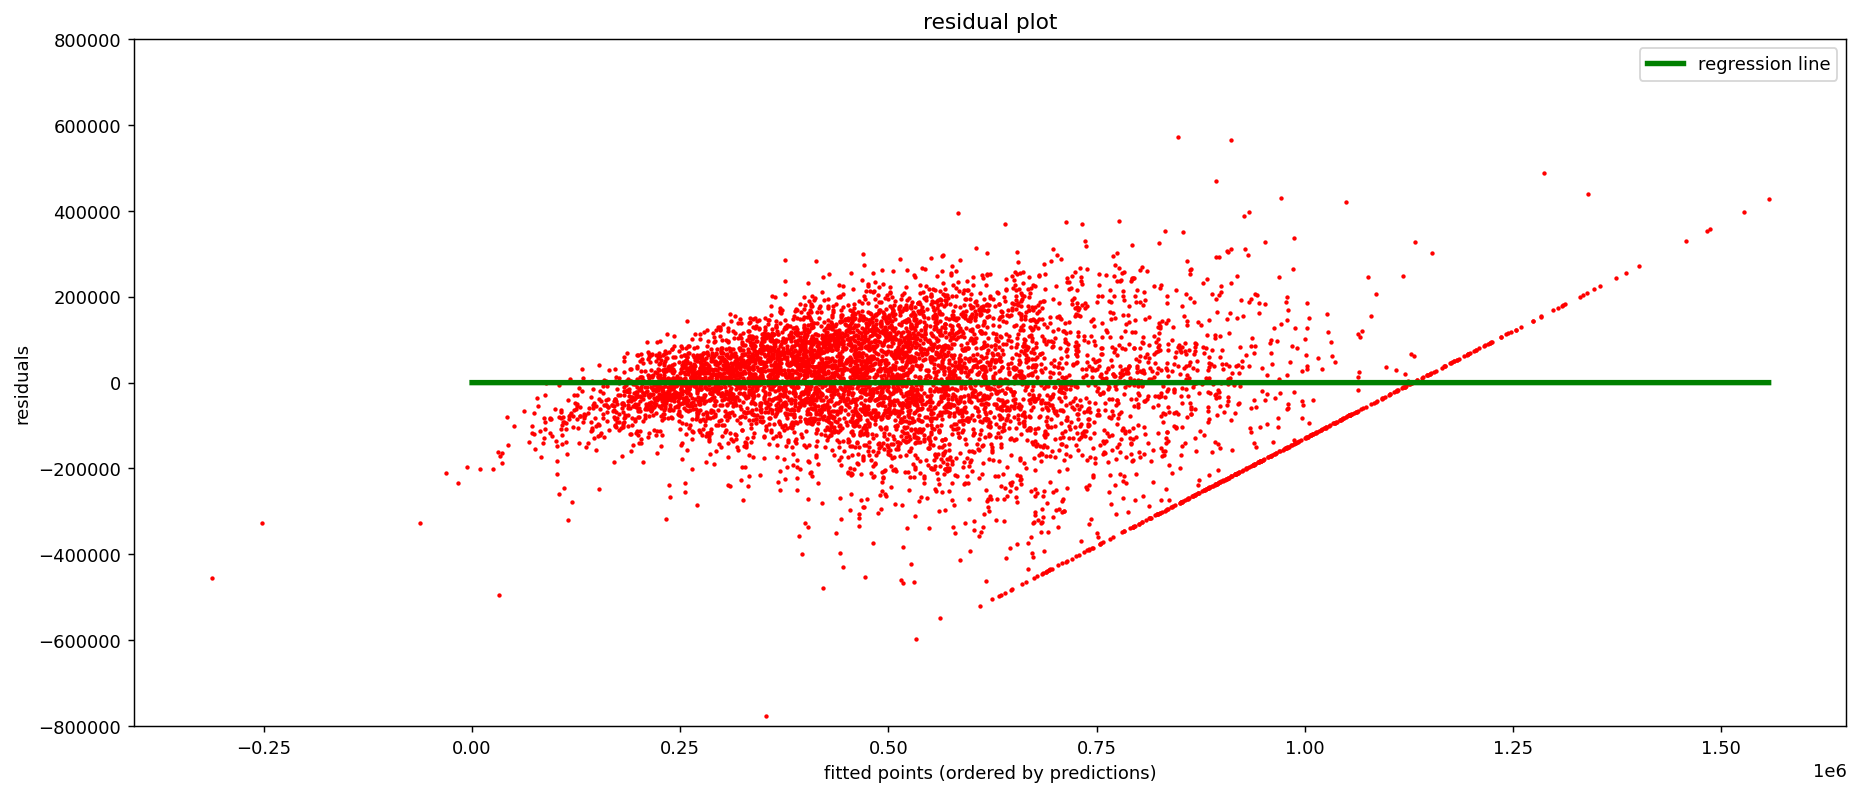

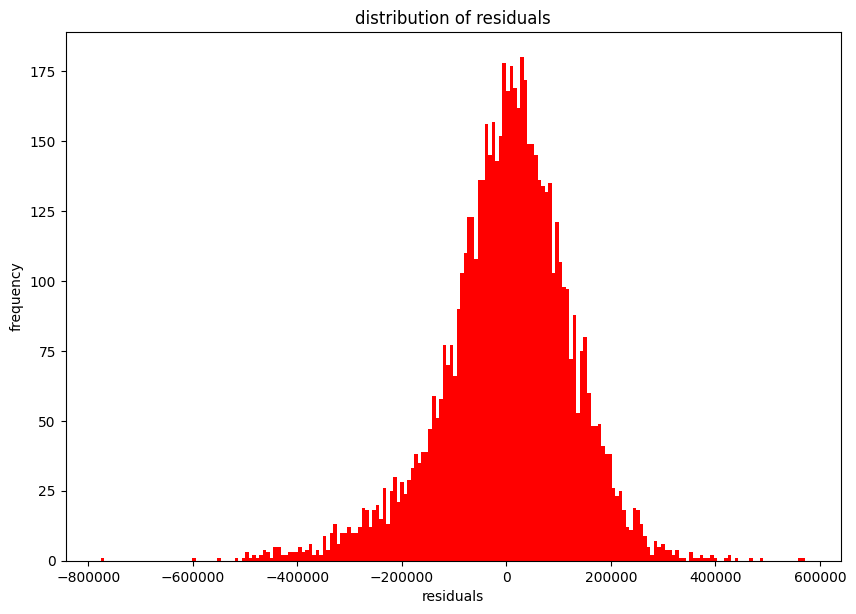

NameError: name 'kl' is not defined

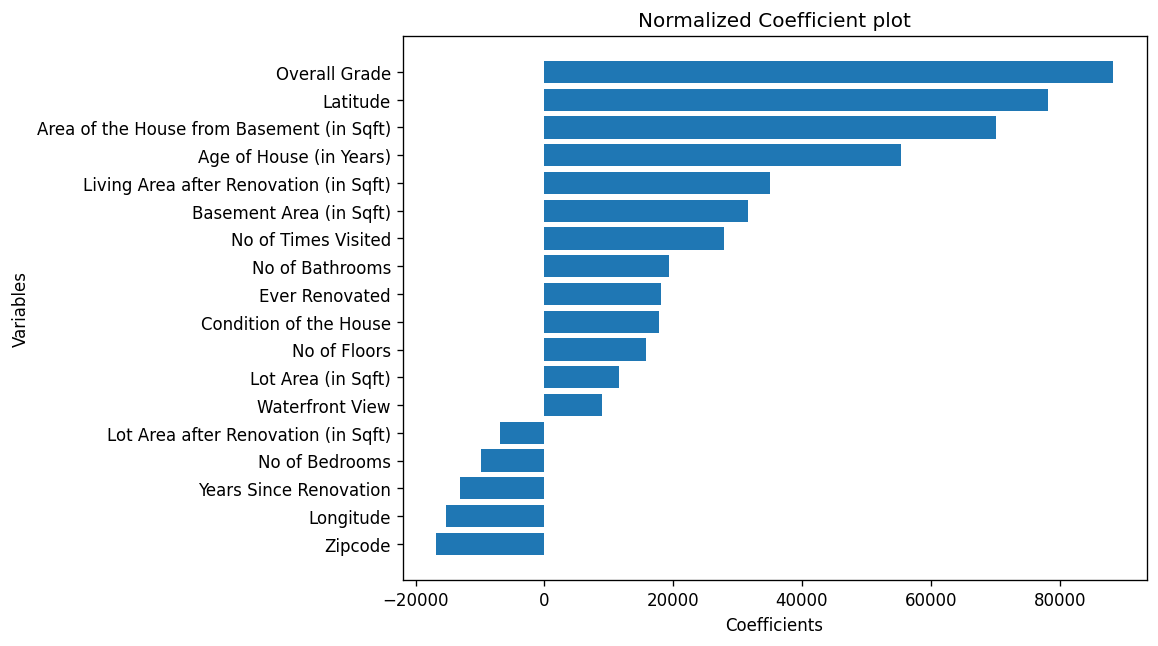

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('Raw_Housing_Prices.csv')

q1 = data['Sale Price'].quantile(0.25)
q3 = data['Sale Price'].quantile(0.75)

iqr = q3 - q1

upper_limit = q3 + 1.5*iqr
lower_limit = q1 - 1.5*iqr

def limit_imputer(value):
  if value > upper_limit:
    return upper_limit
  if value < lower_limit:
    return lower_limit
  else:
    return value

data['Sale Price'] = data['Sale Price'].apply(limit_imputer)

data.dropna(inplace=True,axis=0,subset=['Sale Price'])

#isolating numerical variables
numerical_columns = ['No of Bathrooms', 'Flat Area (in Sqft)','Lot Area (in Sqft)',
                     'Area of the House from Basement (in Sqft)','Latitude',
                     'Longitude','Living Area after Renovation (in Sqft)']

#imputing missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')
data[numerical_columns] = imputer.fit_transform(data[numerical_columns])

#zipcode transform (categorical variable)  ##########################    reshape kyu kiye h

column = data["Zipcode"].values.reshape(-1,1)
imputer = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
data['Zipcode'] = imputer.fit_transform(column)

# converting from string to categorical
mapping = {'None' : "0",
           'Once' : '1',
           'Twice' : '2',
           'Thrice' : '3',
           'Four' : '4'}

data['No of Times Visited'] = data['No of Times Visited'].map(mapping)

# new variable creation
data['Ever Renovated'] = np.where(data['Renovated Year'] == 0, 'No', 'Yes')

#manipulating datetime variable
data['Purchase Year'] = pd.DatetimeIndex(data['Date House was Sold']).year

data['Years Since Renovation'] = np.where(data['Ever Renovated'] == 'Yes',
                                                     abs(data['Purchase Year'] - 
                                                        data['Renovated Year']), 0)

# dropping redundant variables
data.drop( columns = ['Purchase Year', 'Date House was Sold', 'Renovated Year'], inplace = True)           


data.drop( columns = 'ID', inplace = True)

data.dropna(inplace=True)
X = data.drop(columns=['Sale Price'])
Y = data['Sale Price']

X["Waterfront View"] = X["Waterfront View"].map({    'No':0,
   'Yes':1
})


X['Condition of the House'] = X['Condition of the House'].map({'Bad':1,
                                                                     'Okay':2,
                                                                     'Fair':3,
                                                                     'Good':4,
                                                                     'Excellent':5
})

X['Ever Renovated'] = X['Ever Renovated'].map({
    'No':0,
    'Yes':1
})

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Y = data['Sale Price']
X1 = scaler.fit_transform(X)              ###################################################################################3
X = pd.DataFrame(data = X1, columns = X.columns)

## pair of independent variables with correlation greater than 0.5
k = X.corr()
z = [[str(i),str(j)] for i in k.columns for j in k.columns if (k.loc[i,j] > abs(0.5))&(i!=j)]

# Importing Variance_inflation_Factor funtion from the Statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = X

## Calculating VIF for every column
VIF = pd.Series([variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])], index = vif_data.columns)

def MC_remover(data):
  vif = pd.Series([variance_inflation_factor(data.values, i) for i in range(data.shape[1])], index = data.columns) ####################### #shape 1 kyu likha h
  if vif.max() > 5:
    data = data.drop(columns = [vif[vif == vif.max()].index[0]])  ############################      index 0 kyu likha gaya h
    return data
  else:
    return data

for i in range(7):                 ##############################       7       ############################ 
  vif_data = MC_remover(vif_data)  

# Calculating VIF for remaining columns
#############################################################################
VIF = pd.Series([variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])], index = vif_data.columns)

# nahi samaj aaya
################################################################################
X = vif_data

Y = data['Sale Price']

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 101)

from sklearn.linear_model import LinearRegression
lr = LinearRegression(normalize = True)
lr.fit(x_train, y_train)


predictions = lr.predict(x_test)

############################################           lr.score(x_test, y_test)                ###########################################

residuals = predictions - y_test

residual_table = pd.DataFrame({'residuals':residuals,
                    'predictions':predictions})
residual_table = residual_table.sort_values( by = 'predictions')


z = [i for i in range(int(residual_table['predictions'].max()))]   #######################################################
k = [0 for i in range(int(residual_table['predictions'].max()))]   #######################################################

plt.figure(dpi = 130, figsize = (17,7))

plt.scatter( residual_table['predictions'], residual_table['residuals'], color = 'red', s = 2)
plt.plot(z, k, color = 'green', linewidth = 3, label = 'regression line')
plt.ylim(-800000, 800000)
plt.xlabel('fitted points (ordered by predictions)')
plt.ylabel('residuals')
plt.title('residual plot')
plt.legend()
plt.show()

##############################################          graph kyu banaye ye wala           #################################


plt.figure(dpi = 100, figsize = (10,7))
plt.hist(residual_table['residuals'], color = 'red', bins = 200)
plt.xlabel('residuals')
plt.ylabel('frequency')
plt.title('distribution of residuals')
plt.show()

coefficients_table = pd.DataFrame({'column': x_train.columns,
                                  'coefficients': lr.coef_})
coefficient_table = coefficients_table.sort_values(by = 'coefficients')

plt.figure(figsize=(8, 6), dpi=120)
x = coefficient_table['column']
y = coefficient_table['coefficients']
plt.barh( x, y)
plt.xlabel( "Coefficients")
plt.ylabel('Variables')
plt.title('Normalized Coefficient plot')
plt.show()

